# Algorithmically Assign Abx To CSNs based on Model Predictions
## Include patients who are phenotyped as not infected 

In [85]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pulp import *
import os, glob
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score, brier_score_loss
%matplotlib inline

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/Users/conorcorbin/.config/gcloud/application_default_credentials.json' 
os.environ['GCLOUD_PROJECT'] = 'som-nero-phi-jonc101' 
%load_ext google.cloud.bigquery

from google.cloud import bigquery
client=bigquery.Client()

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


/Users/conorcorbin/opt/anaconda3/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


### Load Predictions Data For Each Abx Option

Predictions of coverage for each antibiotic selection are stored in csv files using the following directory schema.  This function reads in predictions for each classifier so that each row is CSN and has an estimated probability of coverage for each antibiotic selection.  We implement a test function that compute the AUROC of each model after the predictions have been read in and cross checks it with the AUROC that was computed and stored in an `auroc.txt` text file during the model training procedure

In [86]:
import pdb
from sklearn.metrics import roc_auc_score

def test_load_predictions(df):
    """
    Reads in output of df, computes AUROC for each classifier and asserts that it equals the AUROC
    listed in the auroc.txt file associate with the classfier's directory
    """
    base_path="/Users/conorcorbin/repos/er_infection/results/ast_models_w_not_infected/testing/{abx}"
    abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]
    for abx in abx_options:
        path = base_path.format(abx=abx)
        f_auroc = os.path.join(path, 'auroc.txt')
        with open(f_auroc, 'r') as f:
            auroc = round(float(f.read()), 3)
        
        computed_auroc = round(roc_auc_score(df['%s_label' % abx], df['%s_predictions' % abx]), 3)
        
        assert auroc == computed_auroc
        print("%s_auroc: %s"% (abx, str(auroc)))

def load_predictions():
    """Helper function that loads predictions from AST classifiers for test set data"""
    
    base_path="/Users/conorcorbin/repos/er_infection/results/ast_models_w_not_infected/testing/{abx}"
    abx_options = ["Vancomycin",
                   "Ampicillin",
                   "Cefazolin",
                   "Ceftriaxone",
                   "Cefepime",
                   "Zosyn",
                   "Ciprofloxacin",
                   "Meropenem",
                   "Vancomycin_Meropenem",
                   "Vancomycin_Zosyn",
                   "Vancomycin_Cefepime",
                   "Vancomycin_Ceftriaxone"
                   ]
    df = pd.DataFrame()
    for i, abx in enumerate(abx_options):
        path = base_path.format(abx=abx)
        f_path = glob.glob(os.path.join(path, '*predictions.csv'))[0]
        if i == 0:
            df = pd.read_csv(f_path)
            df = df[['anon_id', 'pat_enc_csn_id_coded', 'label', 'predictions']]
            df = df.rename(columns={'label' : '%s_label' % abx,
                                    'predictions' : '%s_predictions' % abx})
        else:
            df_preds = pd.read_csv(f_path)
            df_preds = df_preds[['anon_id', 'pat_enc_csn_id_coded', 'label', 'predictions']]
            df_preds = df_preds.rename(columns={'label' : '%s_label' % abx,
                                                'predictions' : '%s_predictions' % abx})
            df = df.merge(df_preds, how='left', on=['anon_id', 'pat_enc_csn_id_coded'])
    
    return df
    
df = load_predictions()
test_load_predictions(df)

Vancomycin_auroc: 0.736
Ampicillin_auroc: 0.686
Cefazolin_auroc: 0.705
Ceftriaxone_auroc: 0.72
Cefepime_auroc: 0.637
Zosyn_auroc: 0.648
Ciprofloxacin_auroc: 0.645
Meropenem_auroc: 0.709
Vancomycin_Meropenem_auroc: 0.759
Vancomycin_Zosyn_auroc: 0.708
Vancomycin_Cefepime_auroc: 0.684
Vancomycin_Ceftriaxone_auroc: 0.715


In [87]:
print(len(df))
df.head()

1599


,anon_id,pat_enc_csn_id_coded,Vancomycin_label,Vancomycin_predictions,Ampicillin_label,Ampicillin_predictions,Cefazolin_label,Cefazolin_predictions,Ceftriaxone_label,Ceftriaxone_predictions,...,Meropenem_label,Meropenem_predictions,Vancomycin_Meropenem_label,Vancomycin_Meropenem_predictions,Vancomycin_Zosyn_label,Vancomycin_Zosyn_predictions,Vancomycin_Cefepime_label,Vancomycin_Cefepime_predictions,Vancomycin_Ceftriaxone_label,Vancomycin_Ceftriaxone_predictions
0,JC2a03b24,131260812263,0,0.218001,0,0.494820,0,0.720949,1,0.822168,...,1,0.919328,1,0.980916,1,0.966854,1,0.975707,1,0.914666
1,JCe45a3c,131260883970,1,0.431339,1,0.609399,0,0.701331,0,0.797252,...,0,0.883213,1,0.980916,1,0.956165,1,0.981404,1,0.925347
2,JCd235bb,131261001599,0,0.538608,0,0.537136,1,0.686221,1,0.805462,...,1,0.862787,1,0.981368,1,0.956677,1,0.964815,1,0.896064
3,JCd29af0,131261001696,0,0.461751,0,0.683057,0,0.578940,0,0.642049,...,1,0.556723,1,0.966940,1,0.946127,1,0.901523,0,0.891276
4,JCd356bf,131261014293,1,0.647562,1,0.660672,1,0.806878,1,0.789645,...,1,0.879717,1,0.976756,1,0.975514,1,0.935165,1,0.904496


### Calibration Classifiers

In [88]:
class IdentityEstimator(LogisticRegression):
    def __init__(self):
        LogisticRegression.__init__(self)
            
    def predict_proba(self, input_array):   
        return input_array*1

    def decision_function(self, input_array):
        return input_array*1

def calibrate_probabilities(predictions, labels):
    """ 
    Takes in test set probabilites and does a k-fold cross fitting procedure to recalibrate each model
    """
    est = IdentityEstimator()
    X = predictions.values.reshape(-1, 1)
    y = labels
    isotonic_calibrated_predictions = np.array([float(i) for i in range(len(y))])
    sigmoid_calibrated_predictions = np.array([float(i) for i in range(len(y))])

    # Fit base estimator
    est.fit(X, y) # because we've overloaded predict_proba and decision function this doesn't matter

    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv='prefit', method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv='prefit', method='sigmoid')

    cv = StratifiedKFold(n_splits=10)
    for train_inds, val_inds in cv.split(X, y):
        X_train, y_train = X[train_inds], y[train_inds]
        X_val, y_val = X[val_inds], y[val_inds]
        isotonic.fit(X_train, y_train)
        isotonic_predictions = isotonic.predict_proba(X_val)
        isotonic_calibrated_predictions[val_inds] = isotonic_predictions[:, 1]

        sigmoid.fit(X_train, y_train)
        sigmoid_predictions = sigmoid.predict_proba(X_val)
        sigmoid_calibrated_predictions[val_inds] = sigmoid_predictions[:, 1]

    
    return sigmoid_calibrated_predictions, isotonic_calibrated_predictions

abx_options = ["Vancomycin",
               "Ampicillin",
               "Cefazolin",
               "Ceftriaxone",
               "Cefepime",
               "Zosyn",
               "Ciprofloxacin",
               "Meropenem",
               "Vancomycin_Meropenem",
               "Vancomycin_Zosyn",
               "Vancomycin_Cefepime",
               "Vancomycin_Ceftriaxone"
               ]

for abx in abx_options:
    predictions = df['%s_predictions' % abx]
    labels = df['%s_label' % abx]
    s_preds, i_preds = calibrate_probabilities(predictions, labels)
    df['%s_predictions_sigmoid' % abx] = s_preds
    df['%s_predictions_isotonic' % abx] = i_preds

In [89]:
# Sanity check AUROCS
for abx in abx_options:
    auc = roc_auc_score(df['%s_label' % abx], df['%s_predictions' % abx])
    auc_s = roc_auc_score(df['%s_label' % abx], df['%s_predictions_sigmoid' % abx])
    auc_i = roc_auc_score(df['%s_label' % abx], df['%s_predictions_isotonic' % abx])
    console_str = "{} AUC Uncalibrated:{:.2f} AUC Sigmoid Calibrated:{:.2f} AUC Isotonic Calibrated:{:.2f}"
    print(console_str.format(abx, auc, auc_s, auc_i))

Vancomycin AUC Uncalibrated:0.74 AUC Sigmoid Calibrated:0.74 AUC Isotonic Calibrated:0.73
Ampicillin AUC Uncalibrated:0.69 AUC Sigmoid Calibrated:0.69 AUC Isotonic Calibrated:0.67
Cefazolin AUC Uncalibrated:0.71 AUC Sigmoid Calibrated:0.70 AUC Isotonic Calibrated:0.69
Ceftriaxone AUC Uncalibrated:0.72 AUC Sigmoid Calibrated:0.72 AUC Isotonic Calibrated:0.70
Cefepime AUC Uncalibrated:0.64 AUC Sigmoid Calibrated:0.64 AUC Isotonic Calibrated:0.62
Zosyn AUC Uncalibrated:0.65 AUC Sigmoid Calibrated:0.64 AUC Isotonic Calibrated:0.61
Ciprofloxacin AUC Uncalibrated:0.64 AUC Sigmoid Calibrated:0.64 AUC Isotonic Calibrated:0.63
Meropenem AUC Uncalibrated:0.71 AUC Sigmoid Calibrated:0.71 AUC Isotonic Calibrated:0.69
Vancomycin_Meropenem AUC Uncalibrated:0.76 AUC Sigmoid Calibrated:0.73 AUC Isotonic Calibrated:0.73
Vancomycin_Zosyn AUC Uncalibrated:0.71 AUC Sigmoid Calibrated:0.71 AUC Isotonic Calibrated:0.66
Vancomycin_Cefepime AUC Uncalibrated:0.68 AUC Sigmoid Calibrated:0.68 AUC Isotonic Calibr

	Brier Uncalibrated: 0.19348
	 Sigmoid Brier: 0.19375
	 Isotonic Brier: 0.19261
	Brier Uncalibrated: 0.22255
	 Sigmoid Brier: 0.22282
	 Isotonic Brier: 0.22467
	Brier Uncalibrated: 0.19579
	 Sigmoid Brier: 0.19593
	 Isotonic Brier: 0.19595
	Brier Uncalibrated: 0.17715
	 Sigmoid Brier: 0.17286
	 Isotonic Brier: 0.17433
	Brier Uncalibrated: 0.13302
	 Sigmoid Brier: 0.13341
	 Isotonic Brier: 0.13513
	Brier Uncalibrated: 0.07227
	 Sigmoid Brier: 0.07253
	 Isotonic Brier: 0.07279
	Brier Uncalibrated: 0.20030
	 Sigmoid Brier: 0.20038
	 Isotonic Brier: 0.20174
	Brier Uncalibrated: 0.11689
	 Sigmoid Brier: 0.11777
	 Isotonic Brier: 0.11886
	Brier Uncalibrated: 0.01992
	 Sigmoid Brier: 0.02038
	 Isotonic Brier: 0.02013
	Brier Uncalibrated: 0.03118
	 Sigmoid Brier: 0.03117
	 Isotonic Brier: 0.03146
	Brier Uncalibrated: 0.02694
	 Sigmoid Brier: 0.02691
	 Isotonic Brier: 0.02711
	Brier Uncalibrated: 0.12176
	 Sigmoid Brier: 0.12142
	 Isotonic Brier: 0.12018


<function matplotlib.pyplot.show(*args, **kw)>

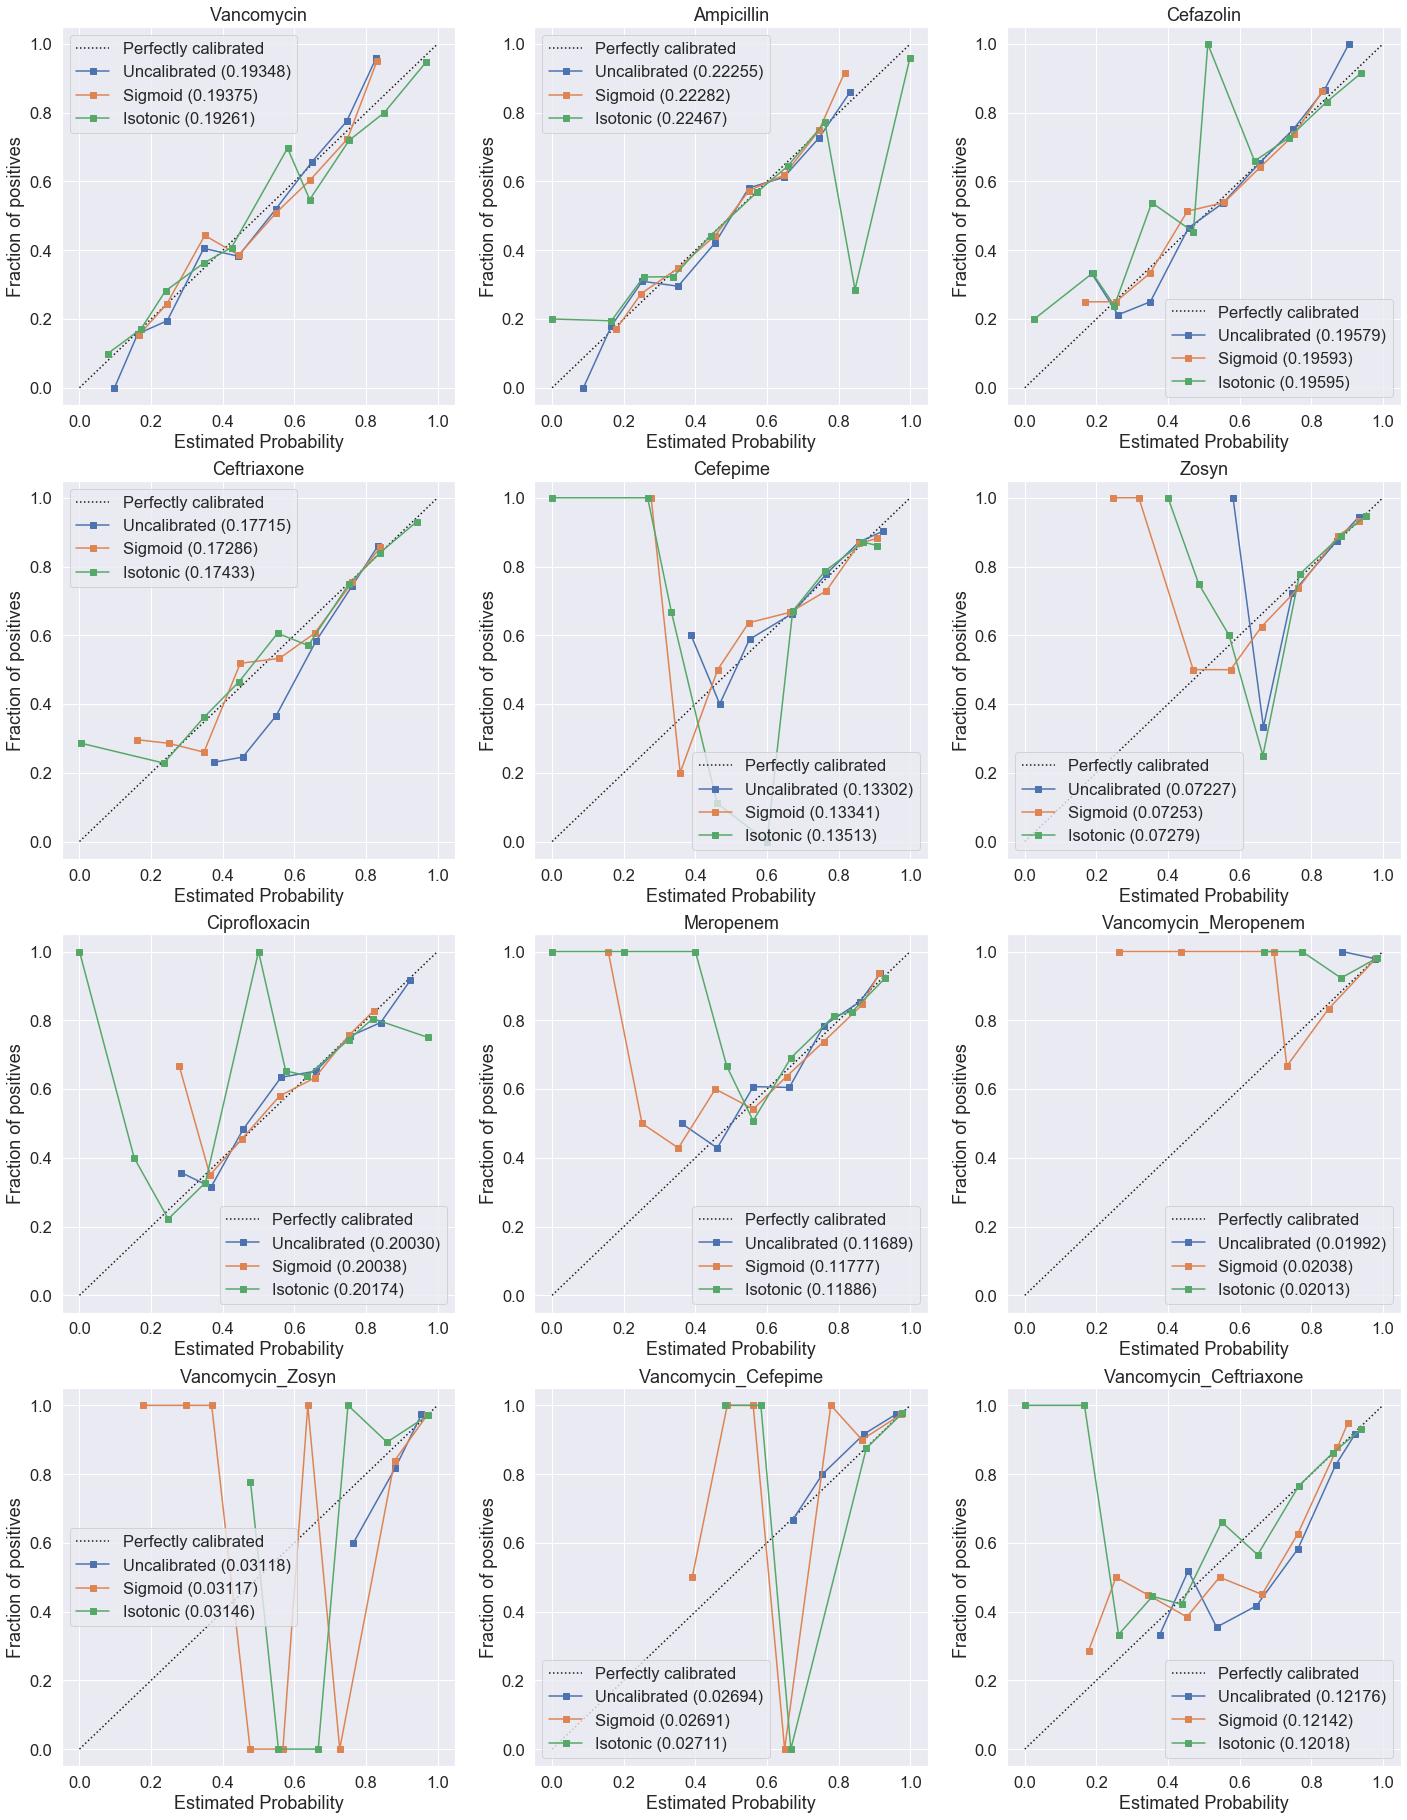

In [71]:
# Plot Calibration Curves
def plot_calibration_curves(df, abx, ax):

    prob_pos = df['%s_predictions' % abx]
    labels = df['%s_label' % abx]
    clf_score = brier_score_loss(labels, prob_pos)
    print("\tBrier Uncalibrated: %1.5f" % (clf_score))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels, prob_pos, n_bins=10)

    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (%1.5f)" % ('Uncalibrated', clf_score))
        
    # Sigmoid 
    clf_score = brier_score_loss(labels, df['%s_predictions_sigmoid'% abx])
    print("\t Sigmoid Brier: %1.5f" % (clf_score))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels, df['%s_predictions_sigmoid'% abx], n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (%1.5f)" % ('Sigmoid', clf_score))
    
    
    # Isotonic curve
    clf_score = brier_score_loss(labels, df['%s_predictions_isotonic'% abx])
    print("\t Isotonic Brier: %1.5f" % (clf_score))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels, df['%s_predictions_isotonic'% abx], n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (%1.5f)" % ('Isotonic', clf_score))
    
    ax.legend()
    ax.set_title(abx)
    ax.set_xlabel('Estimated Probability')
    ax.set_ylabel("Fraction of positives")

fig, ax = plt.subplots(4, 3, figsize=(24, 32))
sns.set(font_scale=1.5)
row, col = 0, 0
for abx in abx_options:
    plot_calibration_curves(df, abx, ax[row, col])
    
    if col == 2:
        col = 0
        row += 1
    else:
        col += 1 
    
plt.show        


### Get clinician prescribing patterns
This SQL query gathers all abx medications ordered within the first 24 hours of admission that were administered to the patient in long format ( one row per administered med_description ) and then joins to our labels table so that we can cross check whether the administered antibiotic was sufficient to cover the patient. 

In [90]:
query = """
WITH adm_abx AS (
    SELECT
        om.anon_id, om.pat_enc_csn_id_coded, om.order_med_id_coded,
        om.med_description, om.order_time
    FROM
        `mining-clinical-decisions.abx.abx_orders_given_and_stopped` om
    WHERE
        om.was_given = 1
), 
not_infected as (
    SELECT 
        anon_id, pat_enc_csn_id_coded, index_time,
        CASE WHEN abx_stopped_2_days = 1
        AND not_discharged_with_orals = 1
        AND no_pos_cult_2_weeks_later = 1
        AND no_pos_cult_within_day = 1
        AND no_inf_dx_codes = 1
        THEN 1 ELSE 0 END not_infected
    FROM 
        `mining-clinical-decisions.abx.cohort_not_infected_rules`
)
SELECT 
    not_infected.not_infected, om.med_description, om.order_med_id_coded, l.*
FROM 
    adm_abx om
RIGHT JOIN 
    `mining-clinical-decisions.abx.final_cohort_table` l
USING
    (pat_enc_csn_id_coded)
INNER JOIN 
    not_infected 
USING 
    (pat_enc_csn_id_coded)
WHERE 
    l.label_unobserved = 0
ORDER BY 
    anon_id, l.pat_enc_csn_id_coded, om.order_time
"""
query_job = client.query(query)
df_abx = query_job.result().to_dataframe()
df_abx.head()

,not_infected,med_description,order_med_id_coded,anon_id,pat_enc_csn_id_coded,index_time,Cefazolin,Ceftriaxone,Cefepime,Zosyn,Vancomycin,Meropenem,Ampicillin,Ciprofloxacin,Vancomycin_Cefepime,Vancomycin_Ceftriaxone,Vancomycin_Meropenem,Vancomycin_Zosyn,label_unobserved
0,1,PIPERACILLIN-TAZOBACTAM-DEXTRS 3.375 GRAM/50 M...,632259709.0,JC29f911a,131275636244,2019-09-12 18:51:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,0
1,1,PIPERACILLIN-TAZOBACTAM-DEXTRS 3.375 GRAM/50 M...,632380542.0,JC29f911a,131275636244,2019-09-12 18:51:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,0
2,1,PIPERACILLIN-TAZOBACTAM-DEXTRS 3.375 GRAM/50 M...,632380557.0,JC29f911a,131275636244,2019-09-12 18:51:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,0
3,1,PIPERACILLIN-TAZOBACTAM-DEXTRS 4.5 GRAM/100 ML...,591650077.0,JC29f91f9,131261805212,2019-01-21 09:27:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,0
4,1,PIPERACILLIN-TAZOBACTAM-DEXTRS 3.375 GRAM/50 M...,591653100.0,JC29f91f9,131261805212,2019-01-21 09:27:00+00:00,1,1,1,1,1,1,1,1,1,1,1,1,0


In [91]:
df_abx[df_abx['med_description'].isna()]
df_abx['med_description'] = df_abx['med_description'].fillna('No Abx Administered')

### Aggregate antibiotic orders 
Here we aggregate the antibiotic orders so that one row in the desulting dataframe corresponds to a unique CSN. We do this by
1. Grouping by the CSN
2. Grabbing the first word (antibiotic name) from the med description
3. Aggregating the `med_description` column such that it is a single string with all antibiotics admistered to the patient, sorted in alphabetical order and separated by spaces. 
4. Only keep CSNs where the set of administered antibiotics is equal to one of the antbiotic selections we've trained classifiers for. 

In [92]:
# Useful dictionaries to map corresponding. strings for the sameantibiotic selections
abx_map = {'Ceftriaxone' : "CEFTRIAXONE",
           'Vancomycin_Zosyn' : "PIPERACILLIN-TAZOBACTAM VANCOMYCIN",
           'Zosyn' : "PIPERACILLIN-TAZOBACTAM",
           'Vancomycin_Ceftriaxone' : "CEFTRIAXONE VANCOMYCIN",
           'Vancomycin_Cefepime' : "CEFEPIME VANCOMYCIN",
           'Cefepime' : "CEFEPIME",
           'Vancomycin' :  "VANCOMYCIN",
           'Meropenem' : "MEROPENEM",
           'Vancomycin_Meropenem' : "MEROPENEM VANCOMYCIN",
           'Cefazolin' : "CEFAZOLIN",
           'Ciprofloxacin' : "CIPROFLOXACIN",
           'Ampicillin' : 'AMPICILLIN'
           #'No Abx' : 'No Abx Administered'
          }
abx_map_inverse = {abx_map[key] : key for key in abx_map}

# Lambda that aggregate Antibiotic orders after we've grouped by CSN
concat_abx = lambda x : ' '.join(np.unique(sorted([a for a in x])))

# 
df_drugs = (df_abx
    .assign(med_description=lambda x: [a.split(' ')[0] for a in x.med_description]) # Only Take first word (abx)
    .assign(med_description=lambda x: [(a.replace('PIPERACILLIN-TAZOBACTAM-DEXTRS','PIPERACILLIN-TAZOBACTAM')
                                        .replace('VANCOMYCIN-WATER', 'VANCOMYCIN'))
                                       for a in x.med_description])
    .assign(year=lambda x: x.index_time.dt.year) # get year of each CSN - used to filter later on
    .groupby('pat_enc_csn_id_coded')
    .agg({'med_description' : concat_abx,
          'not_infected' : 'first',
          'year' : 'first',
          'Ampicillin' : 'first',
          'Ciprofloxacin' : 'first',
          'Cefazolin' : 'first',
          'Ceftriaxone' : 'first',
          'Cefepime' : 'first',
          'Zosyn' : 'first',
          'Vancomycin' : 'first',
          'Meropenem' : 'first',
          'Vancomycin_Ceftriaxone' : 'first',
          'Vancomycin_Cefepime' : 'first',
          'Vancomycin_Zosyn' : 'first',
          'Vancomycin_Meropenem' : 'first'})
    .reset_index()
    # Only look at test set data and CSNs where allowed antibiotic selection was administered
    .query("year == 2019 and med_description in @abx_map_inverse", engine='python') 
)

# Roughly 700 of the 1300 original CSNs in the test set
print(len(df_drugs))
df_drugs

874


,pat_enc_csn_id_coded,med_description,not_infected,year,Ampicillin,Ciprofloxacin,Cefazolin,Ceftriaxone,Cefepime,Zosyn,Vancomycin,Meropenem,Vancomycin_Ceftriaxone,Vancomycin_Cefepime,Vancomycin_Zosyn,Vancomycin_Meropenem
8565,131260812263,CEFTRIAXONE,0,2019,0,1,0,1,1,1,0,1,1,1,1,1
8579,131261001599,PIPERACILLIN-TAZOBACTAM,0,2019,0,1,1,1,1,1,0,1,1,1,1,1
8582,131261014293,CEFTRIAXONE,0,2019,1,1,1,1,1,1,1,1,1,1,1,1
8602,131261155365,CEFTRIAXONE,0,2019,1,1,1,1,1,1,0,1,1,1,1,1
8604,131261167965,MEROPENEM VANCOMYCIN,0,2019,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10362,131282218216,CEFTRIAXONE,1,2019,1,1,1,1,1,1,1,1,1,1,1,1
10373,131282353799,CEFTRIAXONE,0,2019,0,1,1,1,1,1,0,1,1,1,1,1
10376,131282359236,MEROPENEM VANCOMYCIN,0,2019,0,0,0,0,0,0,0,0,1,1,1,1
10386,131282431253,CEFTRIAXONE,0,2019,0,1,0,0,1,1,0,1,0,1,1,1


### Merge this dataframe to predictions dataframe
After this step we should have a dataframe that has one row per CSN, each row should have the antibiotic selection actually administered to the patient, along with the predicted probability of said antibiotic selection covering the patient, and the ground truth as to whether it did. 

In [93]:
# Merge df_total to df on pat_enc_csn_id_coded
base_path="/Users/conorcorbin/repos/er_infection/results/ast_models_w_not_infected/testing/{abx}"
df_new = (df
    .merge(df_drugs, how='inner', on='pat_enc_csn_id_coded')
)

# Sanity check - make sure %abx_label columns are equal to %abx columns
for abx in abx_options:
    for i in range(len(df_new)):
        assert df_new[abx].values[i] == df_new['%s_label' % abx].values[i]
        
# Sanity check 2: compute AUROC of this subset of patients and compare to AUROC on full test set
for abx in abx_options:
    computed_auroc = roc_auc_score(df_new['%s_label' % abx], df_new['%s_predictions' % abx])
    f_auroc = os.path.join(base_path.format(abx=abx), 'auroc.txt')
    with open(f_auroc, 'r') as f:
        auroc = float(f.read())
    print("{}: Full test set AUROC:{:.3f} Subset AUROC:{:.3f}".format(abx, auroc, computed_auroc))

Vancomycin: Full test set AUROC:0.736 Subset AUROC:0.733
Ampicillin: Full test set AUROC:0.686 Subset AUROC:0.683
Cefazolin: Full test set AUROC:0.705 Subset AUROC:0.721
Ceftriaxone: Full test set AUROC:0.720 Subset AUROC:0.726
Cefepime: Full test set AUROC:0.637 Subset AUROC:0.633
Zosyn: Full test set AUROC:0.648 Subset AUROC:0.602
Ciprofloxacin: Full test set AUROC:0.645 Subset AUROC:0.648
Meropenem: Full test set AUROC:0.709 Subset AUROC:0.702
Vancomycin_Meropenem: Full test set AUROC:0.759 Subset AUROC:0.830
Vancomycin_Zosyn: Full test set AUROC:0.708 Subset AUROC:0.722
Vancomycin_Cefepime: Full test set AUROC:0.684 Subset AUROC:0.732
Vancomycin_Ceftriaxone: Full test set AUROC:0.715 Subset AUROC:0.744


### Create Binary Integer Programming Problem Formulation and Solve
Here we specificy the problem formulation of the optimization process we wish to solve. The goal is to maximize the probability of covering the set of patients in the test set with the available antibiotic selections subject to the constraints that we assign each antibiotic selection a prespecified number of times, and that we only assign one antibiotic selection to each patient CSN. 

More technically, Let $N$ be the number of patient CSNs in our test set who were administered one of the 12 abx selections by clinicians, and let $K$ be the number of possible antibiotic selections.  Let $A$ be a matrix in $\mathbb{R}^{N\times K}$ such that $a_{ij}$ is 1 if antibiotic selection $j$ is selected for patient CSN $i$ and 0 otherwise. Let $\Phi$ be a matrix in $\mathbb{R}^{N \times K}$ such that $\phi_{ij}$ is the predicted probability that antibiotic $j$ will cover patient CSN $i$.  Let $C$ be a vector in $\mathbb{R}^K$ such that $c_j$ specifies the budget for anitbiotic selection $j$ - that is the number of times we are allowed to select antibiotic $j$ across our $N$ patient CSNs. Our problem formulation is as follows. 

$$  \underset{A}{\text{maximize}} \sum_{i=1}^{N} \sum_{j=1}^K \phi_{ij} a_{ij} $$

Subject to the following constraints:

$$ \sum_{j=1}^{K} a_{ij} = 1 \quad i = 1, ..., N $$

$$ \sum_{i=1}^{N} a_{ij} = c_j \quad j = 1, ...,  K $$

In the following code, we implenent and solve this optimization process using the pulp python package. 

In [58]:
# Get clinician drug counts
(df_drugs
    .groupby('med_description')
    .agg(num_csns=('pat_enc_csn_id_coded', 'nunique'))
    .reset_index()
    .sort_values('num_csns', ascending=False)
)

,med_description,num_csns
3,CEFTRIAXONE,422
8,PIPERACILLIN-TAZOBACTAM,154
9,PIPERACILLIN-TAZOBACTAM VANCOMYCIN,141
4,CEFTRIAXONE VANCOMYCIN,38
2,CEFEPIME VANCOMYCIN,31
0,CEFAZOLIN,22
10,VANCOMYCIN,20
1,CEFEPIME,15
5,CIPROFLOXACIN,12
7,MEROPENEM VANCOMYCIN,10


In [103]:
abx_model = LpProblem("Antibiotics", LpMaximize)

# Create binary indicators for whether treatment is used
drug_inds = {}
for abx in abx_options:
    drug_inds[abx] = [LpVariable('%s_%d' % (abx, i), lowBound=0, upBound=1, cat='Binary')
                      for i in range(len(df_new))]

# Add objective function to model
per_csn_sum = []
for i in range(len(df_new)):
    _sum = 0
    for abx in abx_options:
        _sum += drug_inds[abx][i] * df_new['%s_predictions_isotonic' % abx].values[i]
    per_csn_sum.append(_sum)
    
abx_model += lpSum(per_csn_sum)

# Add one selection constraint
for i in range(len(df_new)):
    selections = []
    for abx in abx_options:
        selections.append(drug_inds[abx][i])
    abx_model += lpSum(selections) == 1

# Add max assignment constraints
# abx_assignment_constraints = {"Vancomycin" : 13,
#                               "Ampicillin" : 0,
#                               "Cefazolin" : 8,
#                               "Ceftriaxone" : 367,
#                               "Cefepime" : 14,
#                               "Zosyn" : 102,
#                               "Ciprofloxacin" : 8,
#                               "Meropenem" : 9,
#                               "Vancomycin_Meropenem" : 9,
#                               "Vancomycin_Zosyn" :  113,
#                               "Vancomycin_Cefepime" : 23,
#                               "Vancomycin_Ceftriaxone" : 31
#                              }

abx_assignment_constraints = {"Vancomycin" : 20,
                              "Ampicillin" : 54,
                              "Cefazolin" : 22,
                              "Ceftriaxone" : 462,
                              "Cefepime" : 15,
                              "Zosyn" : 100, # 154
                              "Ciprofloxacin" : 12,
                              "Meropenem" : 9,
                              "Vancomycin_Meropenem" : 10,
                              "Vancomycin_Zosyn" :  101,
                              "Vancomycin_Cefepime" : 31,
                              "Vancomycin_Ceftriaxone" : 38
                             }

for drug in drug_inds:
    abx_model += lpSum([drug_inds[drug][i] for i in range(len(df_new))]) == abx_assignment_constraints[drug]

# Solve model
abx_model.solve()
print("Status:", LpStatus[abx_model.status])

# Save selected antibiotic to df_new
abx_decisions = []
for i in range(len(df_new)):
    abx_decision = None
    for abx in abx_options:
        if drug_inds[abx][i].value() == 1:
            abx_decision = abx_map[abx]
    assert abx_decision is not None
    abx_decisions.append(abx_decision)
df_new['IP_med_description'] = abx_decisions


Status: Optimal


### Compare Performance to Clinician Performance
1. Write a function that takes in antibiotic selection and outputs a 1 if that selection covered the patient.  Simple to do, but annoying because of different ways we've named antibiotic selections.
2. Compute fraction of time each patient CSN was covered by the antibiotic selection. 

In [104]:
# Ugly helper function that just does some string mapping
def compute_was_covered(x, decision_column='med_description'):
    """
    Given med description, find appropriate label column and return whether patient was covered during CSN
    Returns "Not in abx options" if abx regimen isn't in our set of 12 options - useful for filtering later
    """
    if decision_column == 'med_description':
        med_description = x.med_description
    elif decision_column == 'random_med_description':
        med_description = x.random_med_description
    elif decision_column == 'IP_med_description':
        med_description = x.IP_med_description
        
    if med_description == "CEFTRIAXONE":
        return x.Ceftriaxone
    elif med_description == "PIPERACILLIN-TAZOBACTAM VANCOMYCIN":
        return x.Vancomycin_Zosyn
    elif med_description == "PIPERACILLIN-TAZOBACTAM":
        return x.Zosyn
    elif med_description == "CEFTRIAXONE VANCOMYCIN":
        return x.Vancomycin_Ceftriaxone
    elif med_description == "CEFEPIME VANCOMYCIN":
        return x.Vancomycin_Cefepime
    elif med_description == "CEFEPIME":
        return x.Cefepime
    elif med_description == "VANCOMYCIN":
        return x.Vancomycin
    elif med_description == "MEROPENEM":
        return x.Meropenem
    elif med_description == "MEROPENEM VANCOMYCIN":
        return x.Vancomycin_Meropenem
    elif med_description == "CEFAZOLIN":
        return x.Cefazolin
    elif med_description == "CIPROFLOXACIN":
        return x.Ciprofloxacin
    elif med_description == "AMPICILLIN":
        return x.Ampicillin
    else:
        return "Not in abx options"

    
# Create flag for whether clinicians covered the patient during the csn, whether a random assignemnt covered patient
# CSN, and whether optimized assignment covered the patient CSN.

df_new = (df_new
    .assign(random_med_description=lambda x: np.random.choice(x.med_description, size=len(x.med_description), replace=False))
)
df_new = (df_new
    #.sample(frac=1.0, replace=True) # bootstrap each iteration
    .assign(was_covered_dr=df_new.apply(lambda x: compute_was_covered(x), axis=1))
    .assign(was_covered_random=df_new.apply(lambda x: compute_was_covered(x, 
                                                                          decision_column='random_med_description'),
                                                                          axis=1))
    .assign(was_covered_IP=df_new.apply(lambda x: compute_was_covered(x, 
                                                                      decision_column='IP_med_description'),
                                                                      axis=1))
)

clin_covered_rate = df_new['was_covered_dr'].sum() / len(df_new)
random_covered_rate = df_new['was_covered_random'].sum() / len(df_new)
ip_covered_rate = df_new['was_covered_IP'].sum() / len(df_new)
console_str = "Random Coverage Rate:{:.4f} Clinician Coverage Rate:{:.4f} Integer Programming Coverage Rate:{:.4f}"
print(console_str.format(random_covered_rate, clin_covered_rate, ip_covered_rate))

df_new_random = (df_new
        .groupby('random_med_description')
        .agg(num_distinct_csns=('pat_enc_csn_id_coded', 'count'),
             num_times_covered_random=('was_covered_random', 'sum'))
        .reset_index()
        .assign(random_covered=lambda x: ['{}/{}'.format(c, t) for c, t in zip(x.num_times_covered_random,
                                                                               x.num_distinct_csns)])
        .rename(columns={'random_med_description' : 'med_description'})
)[['med_description', 'random_covered']]
                 
df_new_clinician = (df_new
        .groupby('med_description')
        .agg(num_distinct_csns=('pat_enc_csn_id_coded', 'count'),
             num_times_covered_dr=('was_covered_dr', 'sum'))
        .reset_index()
        .assign(dr_covered=lambda x: ['{}/{}'.format(c, t) for c, t in zip(x.num_times_covered_dr,
                                                                               x.num_distinct_csns)])
)[['med_description', 'dr_covered']]
                    
df_new_ip = (df_new
        .groupby('IP_med_description')
        .agg(num_distinct_csns=('pat_enc_csn_id_coded', 'count'),
             num_times_covered_IP=('was_covered_IP', 'sum'))
        .reset_index()
        .assign(IP_covered=lambda x: ['{}/{}'.format(c, t) for c, t in zip(x.num_times_covered_IP,
                                                                               x.num_distinct_csns)])
        .rename(columns={'IP_med_description' : 'med_description'})
)[['med_description', 'IP_covered']]

df_new_agg = (df_new_random
    .merge(df_new_clinician, how='outer', on='med_description')
    .merge(df_new_ip, how='outer', on='med_description')
)

df_new_agg

Random Coverage Rate:0.8501 Clinician Coverage Rate:0.8719 Integer Programming Coverage Rate:0.8650


,med_description,random_covered,dr_covered,IP_covered
0,CEFAZOLIN,18/22,19/22,20/22
1,CEFEPIME,11/15,12/15,11/15
2,CEFEPIME VANCOMYCIN,31/31,30/31,30/31
3,CEFTRIAXONE,331/422,338/422,384/462
4,CEFTRIAXONE VANCOMYCIN,36/38,37/38,33/38
5,CIPROFLOXACIN,8/12,11/12,11/12
6,MEROPENEM,7/9,7/9,8/9
7,MEROPENEM VANCOMYCIN,10/10,10/10,8/10
8,PIPERACILLIN-TAZOBACTAM,147/154,145/154,95/100
9,PIPERACILLIN-TAZOBACTAM VANCOMYCIN,135/141,137/141,96/101


### Note two big limitations here
1. Performing a cross fitting procedure on test set to calibrate each classifier on test set 
2. Assuming we have access to the "budget" of antibiotics ahead of time.  Realistically this should be a one at a time problem. Would have to "cross fit" the abx selections, which is possible but would most likely lower performance. 